In [16]:
# Import and Load Config

import sys
sys.path.append(".")

import torch 

from omegaconf import OmegaConf

from dmm.util import instantiate_from_config


def load_model_from_config(config, ckpt):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    # model.cuda()
    model.cpu()
    model.eval()
    return model

# Download the ckpt file at: 

def get_model():
    config = OmegaConf.load("configs/uncon_.yaml")  
    model = load_model_from_config(config, "last.ckpt")
    return model

In [17]:
# Load Model and Sampler

from dmm.models.diffusion.ddim import DDIMSampler

model = get_model()
sampler = DDIMSampler(model) # TODO: Modify this for the uncond model

Loading model from last.ckpt
DDPM: Running in eps-prediction mode
DiffusionWrapper has 459.71 M params.
Keeping EMAs of 458.


In [21]:
# Local RTX3070 Need around 3 mins to generate 1 sample

a = model.sample(batch_size=1)

Sampling t: 100%|██████████| 1000/1000 [23:59<00:00,  1.44s/it]


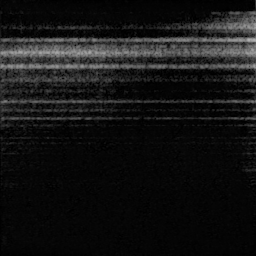

In [22]:
# Plot the sample

images = (a / 2 + 0.5).clamp(0, 1)
images = (images.cpu().permute(0,2,3,1).numpy() * 255).round().astype("uint8")
images = list(
    map(lambda _: Image.fromarray(_[:, :, 0]), images)
    if images.shape[3] == 1
    else map(lambda _: Image.fromarray(_, mode="RGB").convert("L"), images)
)
display(images[0])

In [23]:
# Image to Audio Function
import librosa
from librosa.beat import beat_track
from IPython.display import Audio
import numpy as np

from PIL import Image 

def image_to_audio(image: Image.Image) -> np.ndarray:
    """Converts spectrogram to audio.

    Args:
        image (np.ndarray): x_res x y_res grayscale image

    Returns:
        audio (np.ndarray): raw audio
    """
    bytedata = np.frombuffer(image.tobytes(), dtype="uint8").reshape((image.height, image.width))
    log_S = bytedata.astype("float") * 80 / 255 - 80 # top_db: 80
    S = librosa.db_to_power(log_S)
    audio = librosa.feature.inverse.mel_to_audio(
        S, sr=22050, n_fft=2048, hop_length=512, n_iter=32
    )
    return audio


def loop_it(audio: np.ndarray,
            sample_rate: int = 22050,
            loops: int = 10) -> np.ndarray:
    """Loop audio

    Args:
        audio (np.ndarray): audio as numpy array
        sample_rate (int): sample rate of audio
        loops (int): number of times to loop

    Returns:
        (float, np.ndarray): sample rate and raw audio or None
    """
    _, beats = beat_track(y=audio, sr=sample_rate, units='samples')
    for beats_in_bar in [16, 12, 8, 4]:
        if len(beats) > beats_in_bar:
            return np.tile(audio[beats[0]:beats[beats_in_bar]], loops)
    return None

In [24]:
# Display the audio
audio = image_to_audio(images[0])

audio = loop_it(audio,loops=3)

display(Audio(audio, rate=22050))